In [2]:
from nltk.lm.preprocessing import pad_both_ends
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from cosine_cost import CosineCost, plot_breakpoints
from discourse import plot_discourse, glyph_bound
from horley_encoding import convert_to_horley
from scipy.stats import norm

import numpy as np
import os
import re

In [3]:
# Read and preprocess data

with open('data/I.csv', 'r') as file:
    raw_data_I = [line.split(',')[1][:-1] for line in file.readlines()]

# We remove glyph 999 (separator)
clean_lines_I = [line.replace("(", "").replace(")", "").replace("128", "001V.076").replace('999', '').replace('.076.', '.076-').replace("-022h-", "-").split('-') for line in raw_data_I]

encoded_lines_I = [[convert_to_horley(glyph) for glyph in line] for line in clean_lines_I]

In [4]:
# Automatic extraction of the triads by splitting
# whenever we find glyph 076 as an appendage

sequences_I = []

for line in encoded_lines_I:
    i = 0
    j = 1
    while j < len(line):
        if line[j][-3:] == '.76':
            sequences_I.append(line[i:j])
            i = j
        j += 1

# We will add a special token to represent glyph 076
# when appended to the first glyph of the triad

for i in range(len(sequences_I)):
    sequences_I[i][0] = sequences_I[i][0][:-3]
    sequences_I[i].insert(1, '<76>')

sequences_I = [sequence for sequence in sequences_I if len(sequence) >= 4 and sequence[0] and '?' not in sequence]

In [5]:
# Glyphs that most likely precede 076
padded = [list(pad_both_ends(sequence, 2)) for sequence in sequences_I]
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '<76>' or w[0] == '?')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('600.6', '<76>'), 72.21678532316497),
 (('90', '<76>'), 55.97725134477073),
 (('430', '<76>'), 41.045369181283036),
 (('76', '<76>'), 17.798884463201716),
 (('90.21', '<76>'), 14.802745003862471),
 (('1v', '<76>'), 12.603026928388179),
 (('99', '<76>'), 11.793294103579775),
 (('700', '<76>'), 11.51360631048987),
 (('451', '<76>'), 11.346935382903181),
 (('290.6', '<76>'), 11.094293530144547)]

In [6]:
# Glyphs that most likely follow 076
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[0] != '<76>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('<76>', '200f'), 13.162647855230823), (('<76>', '70'), 8.712309275427721)]

In [7]:
# Glyphs that most likely occur as the final
# element in the sequence
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '</s>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('32', '</s>'), 8.889204782088079),
 (('90f', '</s>'), 8.712309275427721),
 (('22', '</s>'), 5.126336385555975),
 (('59f', '</s>'), 5.126336385555975)]

In [8]:
trigram_measures = TrigramAssocMeasures()

# Now, let's check for the most likely combinations
# of the first (preceding) and second (following 76) glyphs
finder = TrigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '<76>')
finder.score_ngrams(trigram_measures.likelihood_ratio)[:10]

[]

In [9]:
line_str_I = [' '.join(line) for line in encoded_lines_I]

vectorizer = TfidfVectorizer(analyzer="word", token_pattern = '[0-9]+[a-zAZ]*[.0-9]*[a-zAZ]*')
vectorized_text = vectorizer.fit_transform(line_str_I)

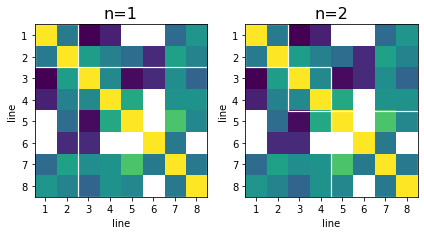

In [10]:
bkpts = plot_breakpoints(vectorized_text, [1, 2])

In [11]:
# Most distinctive glyphs for each segment

feature_names = vectorizer.get_feature_names_out()
X = vectorized_text.toarray()

for bkpt in bkpts:
    indices = [0] + bkpt
    for i in range(len(indices) - 1):
        best_features = np.argmax(X[indices[i]:indices[i+1],:], axis=1)
        print(feature_names[list(set(best_features))])
    print('\n')

['59f' '76']
['1.36' '600' '200.6' '700' '200f']


['59f' '76']
['1.36' '200.6']
['600' '200f' '700']




In [12]:
full_text = []
for line in encoded_lines_I:
    full_text.extend(line)

In [13]:
first_half = {}
second_half = {}

for glyph in set(full_text):
    if '?' not in glyph and full_text.count(glyph) >= 3:
        bounds = glyph_bound(glyph, encoded_lines_I)
        if bounds[1] < 6:
            first_half[glyph] = bounds
        elif bounds[0] >= 6:
            second_half[glyph] = bounds

# sel_glyphs_ordered = sorted(sel_glyphs.keys(), key=lambda x: sel_glyphs[x][0])
sel_glyphs = sorted(list(first_half)) + sorted(list(second_half))
sel_glyphs = [[glyph] for glyph in sel_glyphs]

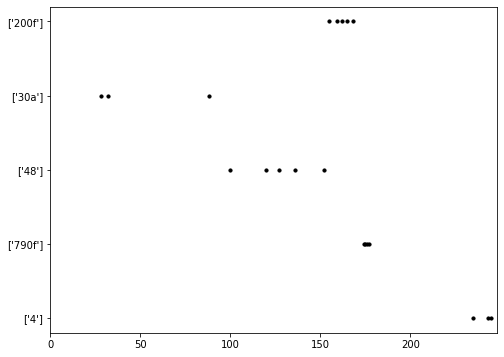

In [14]:
# Distribution of glyphs that appear exclusively
# in the first or second halves

plot_discourse(sel_glyphs, full_text)

In [15]:
common_trigrams = finder.score_ngrams(trigram_measures.likelihood_ratio)

In [16]:
xy_I = [(trigram[0][0], trigram[0][2]) for trigram in common_trigrams]

In [17]:
all_texts = {}

filenames = os.listdir("data/raw_texts/")
for filename in filenames:
    with open(f"data/raw_texts/{filename}", "r") as file:
        lines = file.readlines()
        raw_text = [line.split(',')[1][:-1] for line in lines]
        labels = [line.split(',')[0] for line in lines]
        clean_lines = [line.split('-') for line in raw_text]
        encoded_lines = [[convert_to_horley(glyph) for glyph in line] for line in clean_lines]
        for label, encoded_line in zip(labels, encoded_lines):
            all_texts[label] = ' '.join(encoded_line)

In [18]:
for line in all_texts:
    for pair in xy_I:
        pattern = fr"\b{'(.)'.join(pair)}\b"
        matches = re.findall(pattern, all_texts[line])
        if matches:
            print(line, pair)

In [19]:
def is_similar(a, b):
    a_glyphs = a.split('.')
    b_glyphs = b.split('.')
    if set(a_glyphs) & set(b_glyphs):
        return True
    return False

In [20]:
# sequences where the first and last glyphs are similar
xyx = [seq for seq in sequences_I if is_similar(seq[0], seq[-1])]

# sequences where the first and second glyphs are similar
xxz = [seq for seq in sequences_I if is_similar(seq[0], seq[2])]

# sequences where the second and final glyphs are similar
xyy = [seq for seq in sequences_I if is_similar(seq[2], seq[-1])]

In [21]:
print(len(xyx) / len(sequences_I))
print(len(xxz) / len(sequences_I))
print(len(xyy) / len(sequences_I))

0.2
0.06666666666666667
0.1


In [22]:
def glyph_indices(glyph, text):
    return [i for i, gl in enumerate(text) if gl == glyph]

def nearest_neighbor_analysis_1d(points, length, alpha=0.05):
    n_points = len(points)
    nearest_distances = np.diff(points)
    observed_mean_distance = np.mean(nearest_distances)
    expected_mean_distance = length / (n_points + 1)

    nnr = observed_mean_distance / expected_mean_distance
    
    sd = np.std(nearest_distances, ddof=1)

    standard_error = sd / np.sqrt(n_points)
    z_score = (observed_mean_distance - expected_mean_distance) / standard_error
    
    if abs(z_score) > norm.ppf(1 - alpha / 2):
        if z_score < 0:
            result = "clustered"
        else:
            result = "dispersed"
    else:
        result = "random"
    
    return z_score, result

In [31]:
clustered = []
dispersed = []

for glyph in set(full_text):
    if full_text.count(glyph) >= 4:
        points = glyph_indices(glyph, full_text)
        res = nearest_neighbor_analysis_1d(points, len(full_text))
        if res[1] == "clustered" and "?" not in glyph:
            clustered.append(glyph)
        elif res[1] == "dispersed" and "?" not in glyph:
            dispersed.append(glyph)

/tmp/ipykernel_68088/825426906.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (observed_mean_distance - expected_mean_distance) / standard_error


In [32]:
clustered = sorted(clustered, key=lambda x: glyph_bound(x, encoded_lines_I))
clustered = [[glyph] for glyph in clustered]

In [33]:
sum([len(i) for i in encoded_lines_I][:6])

182

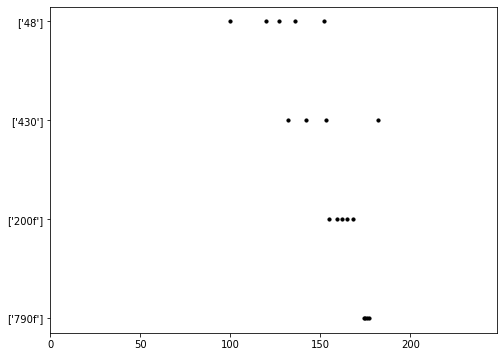

In [34]:
plot_discourse(clustered, full_text)

In [25]:
trigram_lists = [' '.join(trigram[0]).replace(' <76>', '.76').split() for trigram in common_trigrams]

In [26]:
def bigram_indices(x):
    res = []
    for i in range(len(full_text) - len(x) + 1):
        if full_text[i:i+len(x)] == x:
            res.append(i)
    return res

In [27]:
a = []
for i in trigram_lists:
    z = nearest_neighbor_analysis_1d(bigram_indices(i), len(full_text))
    if z[1] != 'random':
        a.append(i)

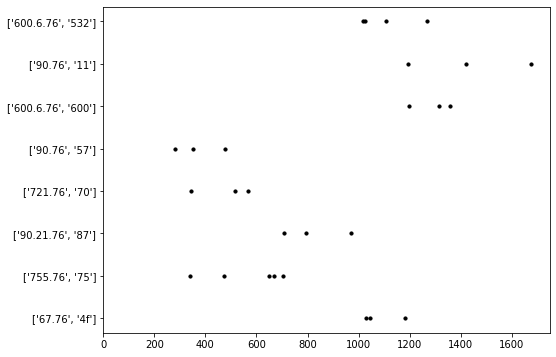

In [28]:
plot_discourse(a, full_text)

In [29]:
import pandas as pd
import scipy.stats as stats

In [30]:
triads = [i for i in sequences_I if len(i) == 4]

In [31]:
X = [i[0] for i in triads if "?" not in i[0]]
Y = [i[2] for i in triads if "?" not in i[2]]
Z = [i[-1] for i in triads if "?" not in i[-1]]

In [32]:
df1 = pd.DataFrame({'glyph': X, 'position': 'X'})
df2 = pd.DataFrame({'glyph': Y, 'position': 'Y'})
df3 = pd.DataFrame({'glyph': Z, 'position': 'Z'})

df = pd.concat([df1,df2,df3])

In [33]:
crosstab = pd.crosstab(df["glyph"], df["position"])

In [34]:
row_sums = crosstab.sum(axis=1)
crosstab = crosstab[row_sums >= 2]

In [35]:
stats.chi2_contingency(crosstab)

Chi2ContingencyResult(statistic=449.67458359732314, pvalue=5.561598864853523e-22, dof=196, expected_freq=array([[ 0.71870398,  0.65684831,  0.62444772],
       [ 0.71870398,  0.65684831,  0.62444772],
       [ 2.15611193,  1.97054492,  1.87334315],
       [ 7.18703976,  6.56848306,  6.24447717],
       [ 1.07805596,  0.98527246,  0.93667158],
       [ 4.67157585,  4.26951399,  4.05891016],
       [ 4.31222386,  3.94108984,  3.7466863 ],
       [ 3.59351988,  3.28424153,  3.12223859],
       [ 4.31222386,  3.94108984,  3.7466863 ],
       [ 0.71870398,  0.65684831,  0.62444772],
       [ 3.23416789,  2.95581738,  2.81001473],
       [ 2.15611193,  1.97054492,  1.87334315],
       [ 0.71870398,  0.65684831,  0.62444772],
       [ 0.71870398,  0.65684831,  0.62444772],
       [ 1.07805596,  0.98527246,  0.93667158],
       [ 0.71870398,  0.65684831,  0.62444772],
       [ 2.15611193,  1.97054492,  1.87334315],
       [ 0.71870398,  0.65684831,  0.62444772],
       [ 3.59351988,  3.2842415

In [36]:
crosstab.sort_values(by='Z')

position,X,Y,Z
glyph,,,
1,1,1,0
522f,1,1,0
95,0,3,0
532.6,0,3,0
430.10,0,2,0
...,...,...,...
27,5,2,7
700,12,4,9
76,11,2,11
